
# 🌐 Proyecto extra — Explorando datos meteorológicos desde una API (Open‑Meteo)

**Unidad:** UT1 – Exploración y Fuentes de Datos  
**Objetivo:** consumir una API pública (JSON), normalizar la respuesta con `pandas` y realizar un EDA básico.  
**Ciudad de ejemplo:** Montevideo, UY

> Nota: este notebook está diseñado para ser **reproducible** y guardar artefactos en `data/openmeteo/` (CSV y Parquet).


In [5]:

import os, json, requests
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 100)


In [6]:

# --- Parámetros (Montevideo aprox.)
LAT, LON = -34.9011, -56.1645
PARAMS = {
    "latitude": LAT,
    "longitude": LON,
    "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m",
    "timezone": "auto"  # usa la TZ local del lugar
}
URL = "https://api.open-meteo.com/v1/forecast"

# Control de ejecución para evitar descargas accidentales repetidas
RUN_FETCH = True  # Cambia a True para ejecutar la descarga


In [7]:

if RUN_FETCH:
    r = requests.get(URL, params=PARAMS, timeout=30)
    r.raise_for_status()
    raw = r.json()
    # Guardar crudo
    out = Path("data/openmeteo")
    out.mkdir(parents=True, exist_ok=True)
    Path(out / "raw_response.json").write_text(json.dumps(raw, ensure_ascii=False, indent=2), encoding="utf-8")
    print("Descarga OK. Respuesta cruda guardada en data/openmeteo/raw_response.json")
else:
    raw = None
    print("RUN_FETCH=False → omitiendo descarga. Cambia a True para descargar datos desde la API.")


Descarga OK. Respuesta cruda guardada en data/openmeteo/raw_response.json


In [9]:

if raw is None:
    print("No hay datos en memoria. Salta esta celda o establece RUN_FETCH=True y vuelve a ejecutar.")
else:
    hourly = raw.get("hourly", {})
    df = pd.DataFrame(hourly)
    assert {"time", "temperature_2m", "relative_humidity_2m", "wind_speed_10m"}.issubset(df.columns),        f"Columnas inesperadas: {df.columns.tolist()}"
    # Tipos/fechas
    df["time"] = pd.to_datetime(df["time"], utc=False)  # ya viene con TZ 'auto'
    df = df.set_index("time").sort_index()
    display(df.head())


,temperature_2m,relative_humidity_2m,wind_speed_10m
time,,,
2025-10-12 00:00:00,19.6,89,14.0
2025-10-12 01:00:00,19.2,90,16.4
2025-10-12 02:00:00,18.4,94,11.9
2025-10-12 03:00:00,16.9,96,10.5
2025-10-12 04:00:00,17.1,96,9.7


In [10]:

if raw is None:
    print("No hay datos para guardar. Establece RUN_FETCH=True y vuelve a ejecutar desde la descarga.")
else:
    out = Path("data/openmeteo")
    out.mkdir(parents=True, exist_ok=True)
    df.to_csv(out / "hourly_montevideo.csv", index=True)
    df.to_parquet(out / "hourly_montevideo.parquet")
    print("Guardado:")
    print(" - data/openmeteo/hourly_montevideo.csv")
    print(" - data/openmeteo/hourly_montevideo.parquet")


Guardado:
 - data/openmeteo/hourly_montevideo.csv
 - data/openmeteo/hourly_montevideo.parquet


In [11]:

if raw is None:
    print("No hay datos. Salta esta celda.")
else:
    df = df.rename(columns={
        "temperature_2m": "temp_c",
        "relative_humidity_2m": "rh_pct",
        "wind_speed_10m": "wind_ms"
    })
    # Validaciones simples de rango
    df = df[(df["temp_c"].between(-40, 60)) & (df["rh_pct"].between(0, 100)) & (df["wind_ms"].between(0, 60))]
    display(df.describe())


,temp_c,rh_pct,wind_ms
count,168.000000,168.000000,168.000000
mean,17.000595,79.708333,12.136310
std,3.664451,15.941643,6.244197
min,10.600000,37.000000,1.100000
25%,14.475000,70.750000,7.775000
50%,16.500000,85.000000,11.700000
75%,18.525000,93.000000,16.100000
max,26.200000,100.000000,30.900000


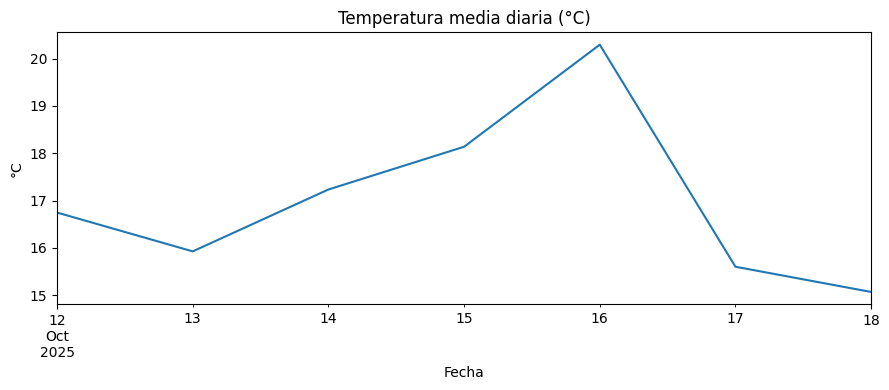

In [12]:

if raw is None:
    print("No hay datos. Salta esta celda.")
else:
    daily = df.resample("D").agg({"temp_c":"mean", "rh_pct":"mean", "wind_ms":"mean"})
    daily["temp_c"].plot(figsize=(9,4), title="Temperatura media diaria (°C)")
    plt.xlabel("Fecha"); plt.ylabel("°C"); plt.tight_layout(); plt.show()


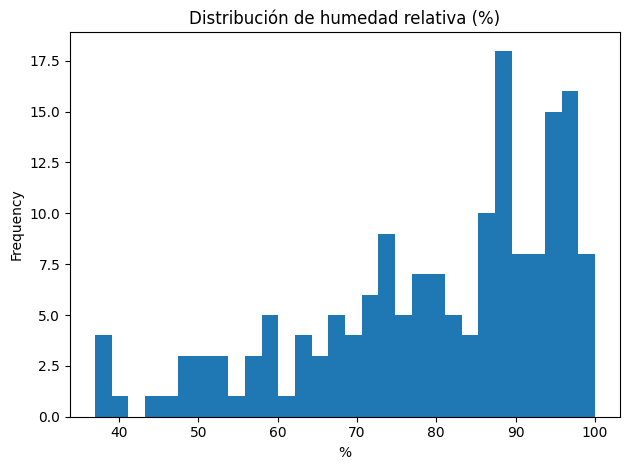

In [13]:

if raw is None:
    print("No hay datos. Salta esta celda.")
else:
    df["rh_pct"].plot(kind="hist", bins=30, title="Distribución de humedad relativa (%)")
    plt.xlabel("%"); plt.tight_layout(); plt.show()


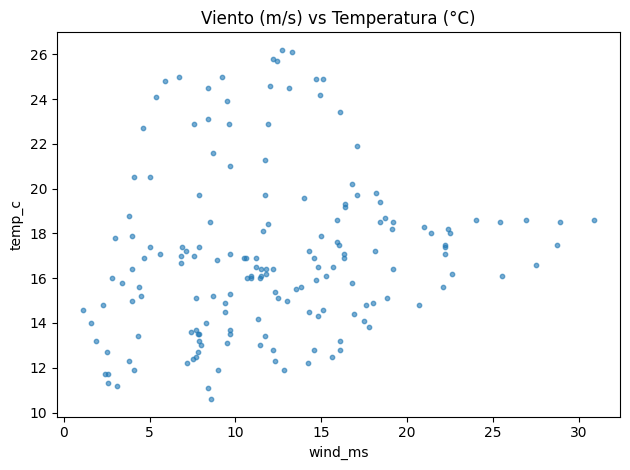

In [14]:

if raw is None:
    print("No hay datos. Salta esta celda.")
else:
    df.plot(x="wind_ms", y="temp_c", kind="scatter", title="Viento (m/s) vs Temperatura (°C)", s=10, alpha=0.6)
    plt.tight_layout(); plt.show()
